In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 16

# Introduction to Qibo

### What is Qibo?
Qibo is an **open-source** full stack API for quantum simulation and quantum hardware
control and calibration.

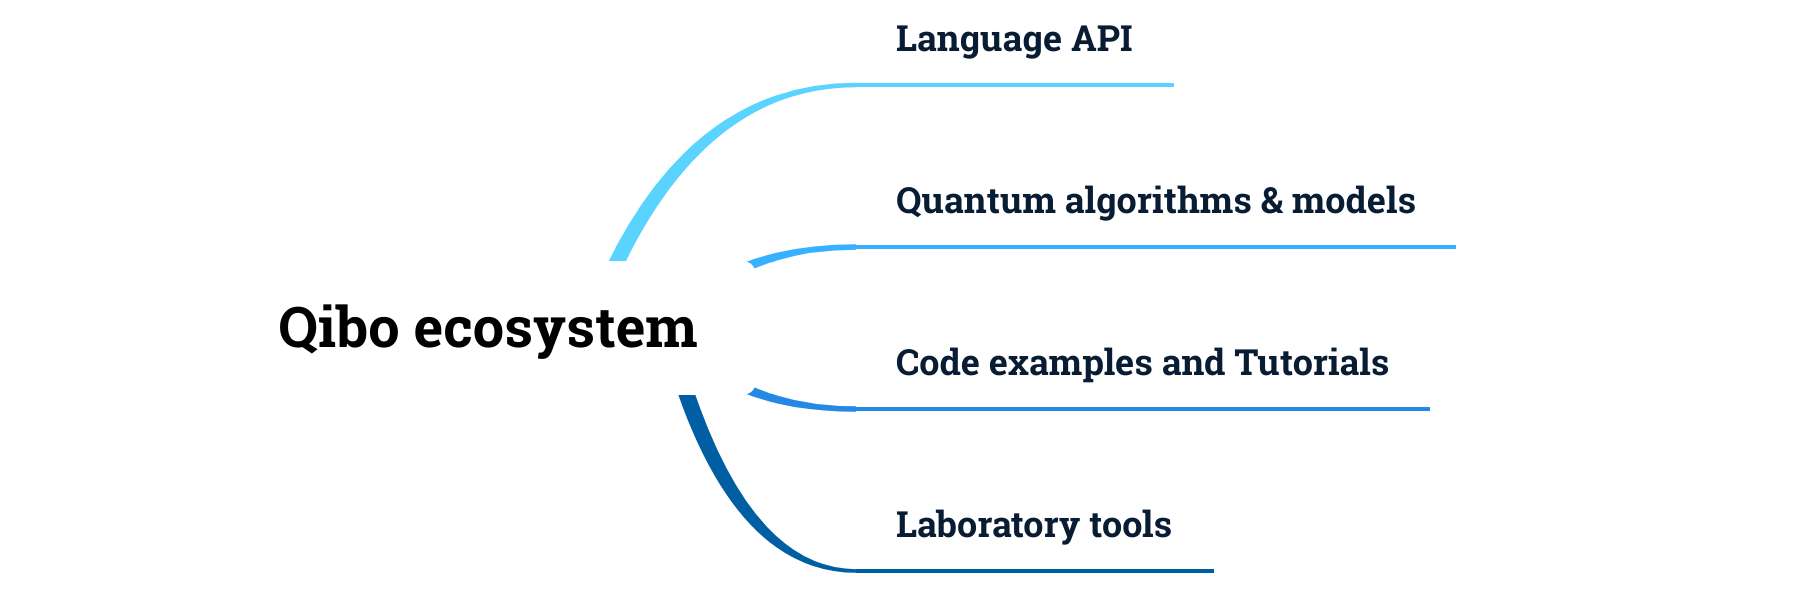

Checkout Qibo on [GitHub](https://github.com/qiboteam/qibo)

## Qibo installation

The easiest way to install Qibo is through pip:

In [ ]:
!pip install qibo

It is also possible to install Qibo from [source](https://qibo.readthedocs.io/en/stable/getting-started/installation.html#installing-from-source) or using [conda](https://qibo.readthedocs.io/en/stable/getting-started/installation.html#installing-with-conda).
For more information check out the [documentation](https://qibo.readthedocs.io/en/stable/getting-started/installation.html).

In [ ]:
from qibo import set_backend
set_backend("numpy")

## Build your first Quantum Circuit using Qibo

Lets start from a simple quantum circuit containing 1 qubit:

In [ ]:
from qibo import models, gates

nqubits = 1
circuit = models.Circuit(nqubits)

By the default the initial state of the qubit is assumend to be $\left | 0 \right \rangle $.
Here is a visual representation of the state on the Bloch sphere.

In [ ]:
def get_spherical_coordinates(statevector):
    # Convert to polar form:
    r0 = np.abs(statevector[0])
    phi0 = np.angle(statevector[0])

    r1 = np.abs(statevector[1])
    phi1 = np.angle(statevector[1])

    # Calculate the coordinates:
    r = np.sqrt(r0 ** 2 + r1 ** 2)
    θ = 2 * np.arccos(r0 / r)
    ϕ = phi1 - phi0
    return [r, θ, ϕ]
  
def plot(state):
    """Auxiliary function to visualize qubit on Bloch sphere"""

    _, theta, phi = get_spherical_coordinates(state)

    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    plt.axis("off")
    ax.view_init(15, 0)

    # Sphere and axes
    phis = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(phis), np.sin(phis), color="black", linewidth=2.0, linestyle="--")
    ax.plot(np.cos(phis), np.sin(phis), zdir="x", color="black", linewidth=2.0)
    ax.plot(np.zeros(100), np.linspace(-1, 1, 100), color="black", linewidth=1.0)
    ax.plot(np.zeros(100), np.linspace(-1, 1, 100), zdir="y", color="black", linewidth=1.0)

    # Bloch sphere axes labels
    ax.text(0, -0.08, 1.15, r"$|0 \rangle $")
    ax.text(0, -0.08, -1.3, r"$|1 \rangle $")
    
    ax.text(0, 0.10, -0.5, "x")
    ax.text(0, 1.2, 0, "y")

    # Define Bloch sphere point
    scat = ax.scatter(x, y, z, color="red", s=50, marker="o")
    # Define Bloch sphere line
    rs = np.linspace(0, 1, 100)
    line, = ax.plot(rs * x, rs * y, rs * z, color="red", linewidth=2.0)

In [ ]:
plot([1,0])

We can modify the qubit state by adding gates to the quantum circuit.

For example, by adding an Hadamard gate $H$, we know that we can create a superposition between the state $\left | 0 \right \rangle $ and the state $\left | 1 \right \rangle $.

In [ ]:
circuit.add(gates.H(0))

Lets simulate the circuit.
To simulate it is sufficient to call the circuit object.

In [ ]:
result = circuit()

In [ ]:
print(result)

As we can see we have created a superposition.

Now our qubit as a 50% probability of being in the state $\left | 0 \right \rangle $ and a 50% probability of being in the state  $\left | 1 \right \rangle $, which corresponds to the following representation on the Bloch sphere.

In [ ]:
plot(result.state())

## Measurements gate

In a real Quantum Device we **do not** have access to the full state vector when executing a Quantum Circuit.

We can only retrieve information from the qubit by perfoming measurements.

In Qibo it is possibile to simulate measurements by adding a measurement gate at the end of the circuit [`gates.M`](https://qibo.readthedocs.io/en/stable/api-reference/qibo.html#measurement-m).

In [ ]:
# lets copy the previous circuit 
new_circuit = circuit.copy()
# and add the measurement gate
new_circuit.add(gates.M(0))

Now when simulating the circuit we must also pass the number of `shots`, which corresponds to the number of times that we measure the circuit.

In [ ]:
shots = new_circuit(nshots=50)

Since we have asked for 50 shots, we can read the 50 samples.

In [ ]:
shots.samples()

And the probabilities of finding the qubit in the two different states.

In [ ]:
shots.probabilities()

We can also access the frequencies, which can be easily plotted in an histogram. 

In [ ]:
frequencies = shots.frequencies()

In [ ]:
def plot_bars(circuit_output):
  probabilities = circuit_output.probabilities()
  frequencies = circuit_output.frequencies()
  labels, values = zip(*frequencies.items())

  values_normalized = np.array(values)/len(circuit_output.samples())

  plt.figure(figsize=(7, 4))
  plt.bar(labels, values_normalized, alpha=0.5, width=0.4, label="Simulation")
  plt.bar(labels, probabilities, alpha=0.5, width=0.4, label="Theory")
  plt.legend()
  plt.show()


In [ ]:
plot_bars(shots)


The results are a bit off, right? Why?

If we increase the number of shots we get the expected result.

In [ ]:
nshots = 10000
plot_bars(new_circuit(nshots = nshots))

## MultiQubit Circuits

Lets move on to circuits with more than one qubit.

In [ ]:
nqubits = 3
multiqubit_circuit = models.Circuit(nqubits=3)

When we add gates, we need to specify to which qubit the gate will be applied.

In [ ]:
# lets add first an H gate to all qubits
multiqubit_circuit.add([gates.H(i) for i in range(nqubits)])
# a CNOT to qubit 1 and 2
multiqubit_circuit.add(gates.CNOT(0, 1))
# and we measure all qubits at the end
multiqubit_circuit.add(gates.M(0,1,2))

To check what your circuit looks like you can call the draw method:

In [ ]:
print(multiqubit_circuit.draw())

Lets execute the circuit

In [ ]:
shots = multiqubit_circuit(nshots=1000)

and plot the results

In [ ]:
plot_bars(shots)

## Applications 0: Quantum Fourier Transform (QFT)

One of the most famous models in Quantum Computing is the Quantum Fourier Transform. It is used in a large variety of quantum algorithms including the Shor's algorithm. It is the quantum counterpart of the classical discrete Fourier transform:

$$ y_k = \sum_{i=0}^{N-1} e^{\frac{2 \pi i k_j}{N}} x_k $$

and can be implemented through the following circuit:

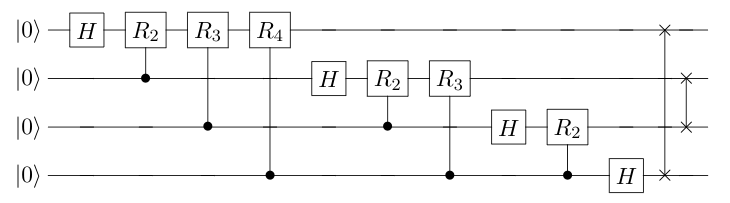



where $R_i$ corresponds to the following gate:

$$ R_i = \begin{pmatrix}
    1 & 0 \\
0 & e^{i \pi/2  \theta_i} 
\end{pmatrix}$$

This model is precoded in Qibo and can be easily imported by the user through the class `models.QFT`.


In [ ]:
qft = models.QFT(nqubits=4)
print(qft.draw())

Lets execute the QFT.

In [ ]:
result_qft = qft()

## Setting the precision 
By default the state vector is stored in double precision, therefore every component of the state vector is a `complex128`. In fact,

In [ ]:
print(type(result_qft.state()[0]))

has dtype `complex128`.

It is possibile to change from double to single precision in the following way:

In [ ]:
from qibo import set_precision
set_precision("single")

By rexecuting the circuit we can see that now the state has dtype `complex64` and no longer `complex128`.

In [ ]:
result_qft_single_precision = qft()
print(type(result_qft_single_precision.state()[0]))